# Tensorflow-Kerasを用いた画像認識モデルの作成と評価

「Shift」＋「Enter」で次々実行できる。

ランタイムは、画像AIに適したGPUを指定すること。

CNNについてはプレゼンテーションに戻って確認する。

## MNISTを用いた畳み込みニューラルネットワークの実装（例）
### データセット① MNISTとは
MNIST(Mixed National Institute of Standards and Technology database)とは、手書き数字画像を、訓練画像60,000枚と、テスト画像10,000枚とを集めた、画像データセット（正解ラベル有り）。画像AIに取り組むときにスタートラインとしてまず取り組むような人気データ。
<br>画像例)

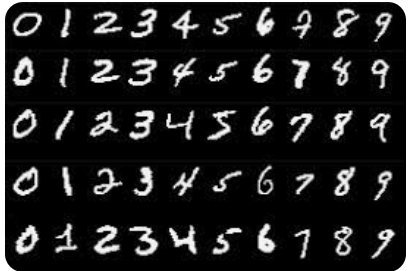

In [1]:
import warnings 
warnings.simplefilter('ignore')
# 必要ライブラリのインポート
import numpy as np  # 数値計算のためのパッケージ
import tensorflow as tf    # Tensorflow
from tensorflow import keras  # Keras
from sklearn.metrics import confusion_matrix, accuracy_score  # モデルの評価を行うための関数

# データの読込
mnist = keras.datasets.mnist
# 訓練データとテストデータの準備
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [2]:
# 皆さんの実行結果が同じになるように乱数シードを固定
import os
import random as rn
from tensorflow.compat.v1.keras import backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.compat.v1.set_random_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

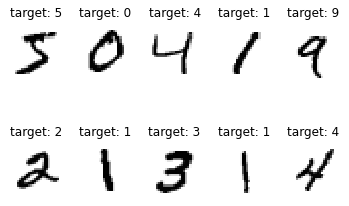

In [4]:
# データの中身の確認
import matplotlib.pyplot as plt  # 可視化のためのモジュール
images_and_labels = list(zip(X_train, y_train))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('target: %i' % label)
plt.show()

In [5]:
# データの形の確認
print("訓練データの特徴量", X_train.shape)
print("訓練データのターゲット", y_train.shape)
print("テストデータの特徴量", X_test.shape)
print("テストデータのターゲット", y_test.shape)

訓練データの特徴量 (60000, 28, 28)
訓練データのターゲット (60000,)
テストデータの特徴量 (10000, 28, 28)
テストデータのターゲット (10000,)


In [6]:
# 1枚当たりのデータ：
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [7]:
# 画像データの正規化
X_train, X_test = X_train / 255.0, X_test / 255.0   # *シグモイド関数などの絵を見せて説明。
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
# 最後の1でチャネル数を記述することで、グレースケールということになります!!

# 公式ページからパラメータ説明
変わるとどうなるのかを知りたい！！！

引数
<br>・filters:	整数、出力空間の次元 (つまり、畳み込みにおける計算フィルターの数)。
<br>・kernel_size:	2D 畳み込みウィンドウの高さと幅を指定する整数または 2 つの整数のタプル/リスト。すべての空間ディメンションに同じ値を指定する単一の整数を指定できます。
<br>・strides:	高さと幅に沿った畳み込みのストライドを指定する、2 つの整数の整数またはタプル/リスト。すべての空間ディメンションに同じ値を指定する単一の整数を指定できます。ストライド値 != 1 を指定することは、値 != 1 を指定することと互換性がありません。 dilation_rate
<br>・padding:	"valid"または(大文字と小文字を区別しない) のいずれか"same"。 "valid"パディングなしを意味します。"same"入力の左右または上下にゼロで均等にパディングされます。padding="same" と の場合strides=1、出力は入力と同じサイズになります。
<br>・activation:使用するアクティベーション関数。何も指定しない場合、アクティベーションは適用されません (「 」を参照keras.activations)。
<br>・use_bias:	レイヤーがバイアス ベクトルを使用するかどうかのブール値。
<br>・kernel_initializer:	重み行列の初期化子kernel( を参照 keras.initializers)。デフォルトは「glorot_uniform」です。
<br>・bias_initializer:	バイアス ベクトルの初期化子 ( を参照 keras.initializers)。デフォルトは「ゼロ」です。
<br>・kernel_regularizer:	重み行列に適用される正規化関数kernel( を参照keras.regularizers)。
<br>・bias_regularizer:	バイアス ベクトルに適用される正規化関数 ( を参照 keras.regularizers)。
<br>・activity_regularizer:	レイヤーの出力に適用されるレギュラー関数 (「アクティベーション」) (「 」を参照keras.regularizers)。
<br>・kernel_constraint:	カーネル マトリックスに適用される制約関数 ( を参照 keras.constraints)。
<br>・bias_constraint:	バイアス ベクトルに適用される制約関数 ( を参照 keras.constraints)。

In [8]:
# 畳み込みニューラルネットワークの実装(同じ)
# import の深度を上げることで記述を楽にできる
# 例)keras.layers.Conv2D() ⇒ Conv2D()
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
model = keras.models.Sequential()
model.add(Conv2D(filters=64, # ≒filterの数。取得できる特徴量が増える
                           kernel_size=(3, 3),
                           strides=1,
                           padding="same",
                           activation="relu", # "relu"でよい
                           input_shape=(28, 28, 1))) # (縦, 横, "チャンネル"=1;白黒, 3;カラー)
model.add(BatchNormalization())  # バッチ正規化層
model.add(MaxPooling2D(pool_size=(2, 2)))  # プーリング層
model.add(Conv2D(filters=64,
                           kernel_size=(3, 3),
                           strides=1,
                           padding="same",
                           activation="relu")) # "relu"でよい
model.add(BatchNormalization())  # バッチ正規化層
model.add(MaxPooling2D(pool_size=(2, 2)))  # プーリング層
model.add(Flatten())  # データを一次元に変形する層
model.add(Dense(units=100, activation="relu")) # "relu"でよい
model.add(BatchNormalization())  # バッチ正規化層
model.add(Dense(units=10, activation="softmax")) # "softmax"でよい

In [9]:
# モデルの学習アルゴリズムの設計
model.compile(optimizer = keras.optimizers.SGD(lr=0.1),
           loss="sparse_categorical_crossentropy",
           metrics=["accuracy"])

In [10]:
# 早期終了（early stopping）の設定
es_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [11]:
# モデルの学習
model.fit(x=X_train,
       y=y_train,
       batch_size=100,  # バッチサイズ
       epochs=100,  # エポック数
       validation_split=0.2,  # 検証データの割合
       callbacks=[es_cb],  # 早期終了の設定
       verbose=1)  # 進捗の確認を行うか（0:行わない, 1:行う） 
# 初手(1epoch目)の予測精度が低い。次のセルで重要な前処理を行う。

Epoch 1/100
480/480 [==============================] - 12s 8ms/step - loss: 0.1082 - accuracy: 0.9685 - val_loss: 0.2703 - val_accuracy: 0.9334
Epoch 2/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0391 - accuracy: 0.9887 - val_loss: 0.0476 - val_accuracy: 0.9856
Epoch 3/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0252 - accuracy: 0.9931 - val_loss: 0.0348 - val_accuracy: 0.9905
Epoch 4/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0171 - accuracy: 0.9957 - val_loss: 0.0327 - val_accuracy: 0.9893
Epoch 5/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0127 - accuracy: 0.9967 - val_loss: 0.0396 - val_accuracy: 0.9873
Epoch 6/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0078 - accuracy: 0.9988 - val_loss: 0.0321 - val_accuracy: 0.9905
Epoch 7/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.0338 - val_accuracy: 0.990

### 重要な前処理

In [12]:
# 重要な前処理がある。得られる変化が大きい
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train, X_test = X_train/255.0, X_test/255.0 から、下のように変更する
X_train, X_test = X_train/255.0-0.5, X_test/255.0-0.5 # ⇒初めからReLU関数の x < 0 の部分にひっかける
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [13]:
# モデルの学習
model.fit(x=X_train,
       y=y_train,
       batch_size=100,  # バッチサイズ
       epochs=100,  # エポック数
       validation_split=0.2,  # 検証データの割合
       callbacks=[es_cb],  # 早期終了の設定
       verbose=1)  # 進捗の確認を行うか（0:行わない, 1:行う）

Epoch 1/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0352 - val_accuracy: 0.9912
Epoch 2/100
480/480 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0286 - val_accuracy: 0.9927
Epoch 3/100
480/480 [==============================] - 3s 7ms/step - loss: 7.8092e-04 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9921
Epoch 4/100
480/480 [==============================] - 3s 7ms/step - loss: 6.6914e-04 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9930
Epoch 5/100
480/480 [==============================] - 3s 7ms/step - loss: 7.4412e-04 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9925
Epoch 6/100
480/480 [==============================] - 3s 7ms/step - loss: 4.6528e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9929
Epoch 7/100
480/480 [==============================] - 3s 7ms/step - loss: 4.0446e-04 - accuracy: 1.0000 - val_loss: 0.0282 - 

In [14]:
# 混同行列による評価
y_proba = model.predict(X_test)
y_pred = np.argmax(y_proba, axis=1)
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

313/313 [==============================] - 1s 2ms/step
[[ 978    0    1    0    0    0    0    1    0    0]
 [   0 1132    1    1    0    0    0    1    0    0]
 [   0    1 1024    1    1    0    0    4    1    0]
 [   0    0    1 1003    0    4    0    1    1    0]
 [   0    0    0    0  978    0    1    0    0    3]
 [   0    0    0    6    0  884    1    0    1    0]
 [   4    2    1    0    1    3  944    0    3    0]
 [   0    2    5    0    0    0    0 1021    0    0]
 [   0    1    0    0    0    1    0    0  971    1]
 [   1    0    1    0    4    2    0    3    1  997]]


In [15]:
# 正答率による評価
print("正解率:", accuracy_score(y_test, y_pred))

正解率: 0.9932


### 考察

今回は-0.5をしない方が予測結果が良くなった。
<br>しかし、filter=16⇒64などの変更や初期値の運などもあるため、何回か実行してみることが重要。

In [16]:
# kerasのセッションの初期化
# 一度、モデルの評価までが終わったら、一度kerasのセッションを初期化する。
# tensorboardが適切に動くために必要なので、この操作はやったほうがBetter。
keras.backend.clear_session()

***

## Fashion-MNISTを用いた畳み込みニューラルネットワークの実装（演習）

In [17]:
import os
import numpy as np
import random as rn
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras

In [18]:
# データの読込
fashion_mnist = keras.datasets.fashion_mnist
# 訓練データとテストデータの準備
(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()
# データの形の確認
print("訓練データの特徴量", X_train0.shape)
print("訓練データのターゲット", y_train0.shape)
print("テストデータの特徴量",X_test0.shape)
print("テストデータのターゲット", y_test0.shape)

4422102/4422102 [==============================] - 0s 0us/step
訓練データの特徴量 (60000, 28, 28)
訓練データのターゲット (60000,)
テストデータの特徴量 (10000, 28, 28)
テストデータのターゲット (10000,)


In [19]:
# 学習の再現を行うために乱数シードを固定するためのコード
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.compat.v1.set_random_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

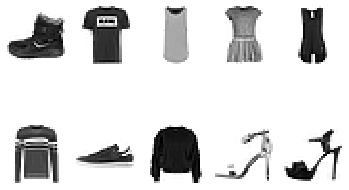

In [20]:
# データの中身の確認
images_and_labels = list(zip(X_train0, y_train0))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [21]:
# 画像データの正規化
X_train = X_train0.reshape(X_train.shape[0], 28, 28, 1)/255.-0.5
X_test = X_test0.reshape(X_test.shape[0], 28, 28, 1)/255.-0.5 # この引き算は強力
X_train.shape

(60000, 28, 28, 1)

### 演習

In [22]:
# モデルを作成してください！！！まずは、上のものをそのままうつしてok
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import # Dense, BatchNormalizationなど、使うものを表記


SyntaxError: ignored

In [ ]:
# モデルの学習アルゴリズムの設計
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
# 早期終了（early stopping）の設定
from tensorflow import keras
es = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

In [ ]:
model.fit(X_train, y_train, epochs=128, validation_split=0.2, 
         callbacks = [es], verbose=1) # callbacks = [es], 

In [ ]:
# 混同行列の表示
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(X_test),axis=1)
cm = confusion_matrix(y_test, y_pred)
print('混同行列')
print(cm)

In [ ]:
# 正解率の表示
model.evaluate(X_test, y_test)

### 総括
上記90%を超えるようにネット記事など調査して精度を改善してみるとよい。
<br>おすすめ書籍は次：https://www.amazon.co.jp/scikit-learn%E3%80%81Keras%E3%80%81TensorFlow%E3%81%AB%E3%82%88%E3%82%8B%E5%AE%9F%E8%B7%B5%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92-%E7%AC%AC2%E7%89%88-Aur%C3%A9lien-G%C3%A9ron/dp/4873119286/ref=asc_df_4873119286/?tag=jpgo-22&linkCode=df0&hvadid=342595526565&hvpos=&hvnetw=g&hvrand=11286794309972209861&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1009303&hvtargid=pla-967836335225&psc=1&th=1&psc=1

<br>また、今回は、tensorflow-kerasの学習に適した、画像処理AIを扱ったが、テーブルデータについてはDense、BatchNormalizationなどを用いるだけでより簡単に着手できる。

テーブルデータについてもtensorflow-kerasの活用を試してみるとよい。

終わりに

今回、AIとtensorflow, kerasを導入するにあたり、理解が容易な画像を題材に選んだ。弊社からAI人材も輩出できればうれしいと思っている。

この先どのような展望があるのかについて述べておく。画像AIでは、例えば次のようなことが可能だ。
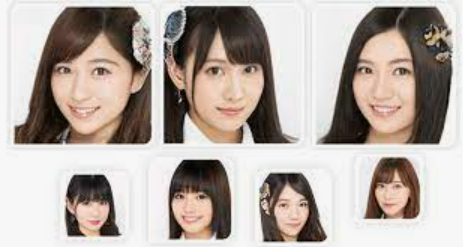
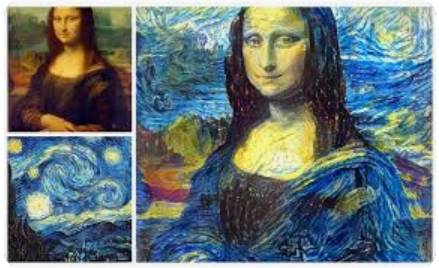
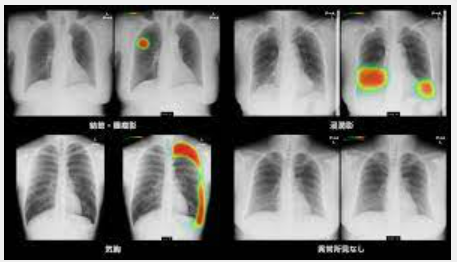





上記、左上：AIで架空アイドル画像を自動生成する、右上：画家の書くスタイルを変換する、左下：AIでがんを検知する　例である。このように、AIと画像の組み合わせは、とても面白いことができるので、自分でも「AI　画像　ニュース」など調べて興味を深めてもらえると嬉しい。


(畳み込み計算の答え)

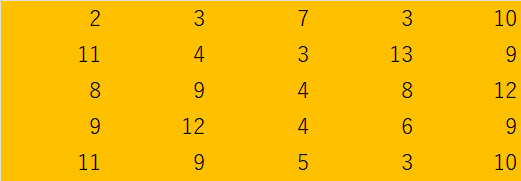